# Canny Edge Detection

**Initialization**

In [11]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
    
import lib.pgm as libpgm
import lib.conv as libconv
import lib.point as libpoint
import lib.edge as libedge
import lib.smooth as libsmooth

**Read PGM**

In [35]:
pgm_path = '../assets/pgms/gman2.ascii.pgm';
pgm = libpgm.read(pgm_path)

**Helper Functions**

In [36]:
def pgm_to_image(pgm):
    (pixels, dims, *_) = pgm[:]
    return np.array(pixels).reshape(dims).tolist()
    
def show_image(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)

## Find Edges with Canny

In [61]:
import math
from lib.utils import array2d
from lib.point import apply_minmax

def filter_edges(image, kernel_x, kernel_y, findDirections=False):
    im_width = len(image[0])
    im_height = len(image)
    kr_size = len(kernel_x)
    kr_padding = kr_size - 1
    out_width = im_width - kr_padding
    out_height = im_height - kr_padding   
    output = array2d(out_width, out_height)
    directions = None
    
    if findDirections:
        directions = array2d(out_width, out_height)
    
    for r in range(out_height):
        for c in range(out_width):
            output_x = 0
            output_y = 0
            for i in range(kr_size):
                for j in range(kr_size):
                    output_x += image[r+i][c+j] * kernel_x[i][j]
                    output_y += image[r+i][c+j] * kernel_y[i][j]
                    
            output[r][c] = math.sqrt(output_x**2 + output_y**2)
            
            if findDirections:
                direction = math.degrees(math.atan2(output_y, output_x))
                directions[r][c] = direction
    
    if findDirections:
        return (output, directions)
    
    return output

def sobel(image, findDirections=False):
    sobel_kernel_x = [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ]

    sobel_kernel_y = [
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ]
    
    return filter_edges(image, sobel_kernel_x, sobel_kernel_y, findDirections)

def canny(image, gauss_sigma, tl, th):
    # 1) apply gaussian filter
    gauss_kernel_size = 5
    gauss_kernel = libsmooth.create_gaussian_kernel(gauss_kernel_size, gauss_sigma)
    image = libconv.convolve2d(image, gauss_kernel);
    
    # 2) find intensity gradient (aka edges with sobel)
    (image, directions) = sobel(image, findDirections=True)
    map(apply_minmax, image)
    
    # 3) apply non-maximum supression
    print(len(directions), len(directions[0]))
    
    # 4) apply hysteresis-threshold
    
    return image

585 585


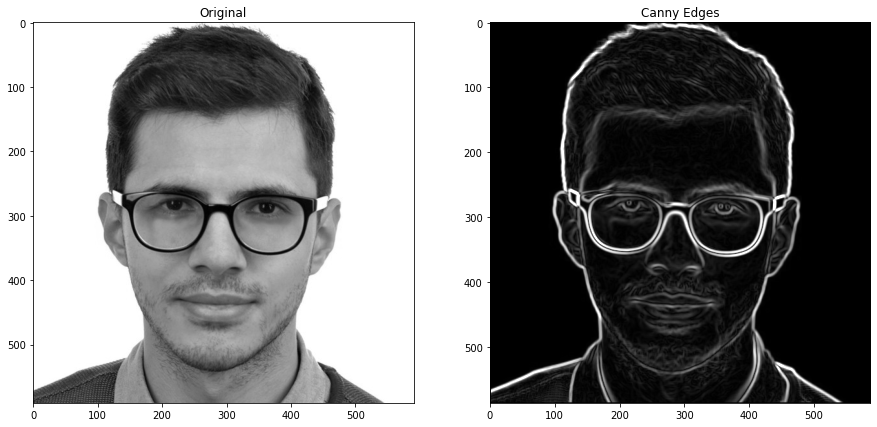

In [62]:
plt.figure(figsize=(15, 15), dpi=72)
plt.subplot(1, 2, 1)
plt.gca().set_title('Original')
libpgm.show(pgm)  

# 1
gauss_sigma = 8
threshold_low = 100
threshold_high = 200

image = pgm_to_image(pgm)
image = canny(image, gauss_sigma, threshold_low, threshold_high)
libconv.pad_zero(image)
map(libpoint.apply_minmax, image)

plt.subplot(1, 2, 2)
plt.gca().set_title('Canny Edges')
show_image(image)